In [20]:
from google.colab import files
uploaded = files.upload()

In [21]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import pandas as pd

Survival:  {1: 225, 2: 81}
Sensitivity :  1.0


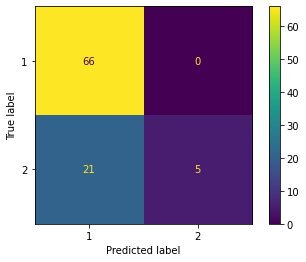

In [22]:
#---------------------------- model uczenia maszynowego 
#---------------------------- policzenie wybranego optymalizowanego parametru
#---------------------------- narysowanie macierzy pomyłek

col_names = ["Age", "Year", "Nodes detected", "Survival"]
df = pd.read_csv("haberman.data", sep=',', header=None, error_bad_lines=False, na_values="?")
df.columns = col_names
df = df.sort_values(by=['Survival'])

counts = dict()
for cls in df['Survival']:
  if cls in counts:
    counts[cls] += 1
  else:
    counts[cls] = 1
print("Survival: ", counts)

X = df[["Age", "Year", "Nodes detected"]]
y = df["Survival"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

clf = RandomForestClassifier(n_estimators=100, max_depth=4)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
metrics.plot_confusion_matrix(clf, X_test, y_test)

cm1 = metrics.confusion_matrix(y_test, y_pred)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

In [23]:
#---------------------------- przetestowanie i porównanie kilku hiperparametrów
grid_param = {  
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [4, 5, 6, 7],
}

for i in grid_param['n_estimators']:
  for j in grid_param['max_depth']:
    clf.set_params(n_estimators=i, max_depth=j)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    cm1 = metrics.confusion_matrix(y_test, y_pred)
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity [' + str(i) + ',' + str(j) + '] : ', str(sensitivity1))

Sensitivity [50,4] :  0.9848484848484849
Sensitivity [50,5] :  0.8939393939393939
Sensitivity [50,6] :  0.8787878787878788
Sensitivity [50,7] :  0.8939393939393939
Sensitivity [100,4] :  1.0
Sensitivity [100,5] :  0.9090909090909091
Sensitivity [100,6] :  0.8787878787878788
Sensitivity [100,7] :  0.9090909090909091
Sensitivity [200,4] :  0.9848484848484849
Sensitivity [200,5] :  0.9393939393939394
Sensitivity [200,6] :  0.8939393939393939
Sensitivity [200,7] :  0.8939393939393939
Sensitivity [500,4] :  0.9848484848484849
Sensitivity [500,5] :  0.9696969696969697
Sensitivity [500,6] :  0.8939393939393939
Sensitivity [500,7] :  0.8939393939393939


{'max_depth': 4, 'n_estimators': 50}
Best sensitivity:  0.9848484848484849


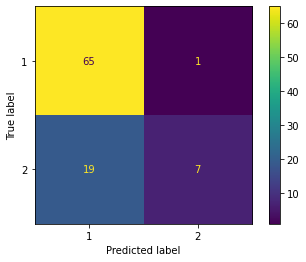

In [24]:
#---------------------------- zastosowanie walidacji krzyżowej do znalezienia optymalnych
#---------------------------- hiperparametrów (u nas n_estimators i max_depth) na siatce
#---------------------------- policzenie wybranego optymalizowanego parametru na zbiorze testowym 
#---------------------------- dla optymalnego klasyfikatora i narysowanie dla niego macierzy pomyłek
grid_search = GridSearchCV(estimator=clf,param_grid=grid_param,cv=10)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_  
print(best_parameters)

clf = RandomForestClassifier(**best_parameters)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
cm1 = metrics.confusion_matrix(y_test, y_pred)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Best sensitivity: ', str(sensitivity1))
metrics.plot_confusion_matrix(clf, X_test, y_test)

In [25]:
#---------------------------- Zbadanie wpływu normalizacji, standaryzacji i PCA (na cechach będących
#---------------------------- liczbami rzeczywistymi) na proces uczenia 
def normalize(X):
  column_maxes = X.max()
  X_max = column_maxes.max()
  normalized_X = X / X_max
  return normalized_X

def standardize(X):
  standardized_X=pd.DataFrame(StandardScaler().fit_transform(X))
  return standardized_X

def PCA_1(X):
  pca = decomposition.PCA(n_components=3, svd_solver='full')
  pca.fit(X)
  X = pca.transform(X)
  return X

def PCA_2(X):
  pca = decomposition.PCA(n_components=2, svd_solver='arpack')
  pca.fit(X)
  X = pca.transform(X)
  return X

In [26]:
hyper_param = {  
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [4, 5, 6, 7],
    'procedure': ['none', 'normalization', 'standardization', 'PCA(3)', 'PCA(2)'],
}

X = df[["Age", "Year", "Nodes detected"]]
y = df["Survival"]

best_sensitivity = 0
best_params = [0,0,'']

for p in hyper_param['procedure']:
  if (p == 'normalization'):
    X = normalize(X)
  elif (p == 'standardization'):
    X = standardize(X)
  elif (p == 'PCA(3)'):
    X = PCA_1(X)
  elif (p == 'PCA(2)'):
    X = PCA_2(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
  clf = RandomForestClassifier()

  for i in hyper_param['n_estimators']:
    for j in hyper_param['max_depth']:
      clf.set_params(n_estimators=i, max_depth=j)
      clf.fit(X_train,y_train)
      y_pred=clf.predict(X_test)
      cm1 = metrics.confusion_matrix(y_test, y_pred)
      sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
      print('Sensitivity [' + str(i) + ',' + str(j) + ',' + str(p) + '] : ', str(sensitivity1))

      if (sensitivity1 > best_sensitivity):
        best_sensitivity = sensitivity1
        best_params = [i,j,p]

print('Best sensitivity [' + str(best_params[0]) + ',' + str(best_params[1]) + ',' + str(best_params[2]) + '] : ', str(best_sensitivity))

Sensitivity [50,4,none] :  0.9848484848484849
Sensitivity [50,5,none] :  0.9242424242424242
Sensitivity [50,6,none] :  0.8484848484848485
Sensitivity [50,7,none] :  0.8484848484848485
Sensitivity [100,4,none] :  0.9393939393939394
Sensitivity [100,5,none] :  0.9393939393939394
Sensitivity [100,6,none] :  0.8939393939393939
Sensitivity [100,7,none] :  0.8484848484848485
Sensitivity [200,4,none] :  0.9545454545454546
Sensitivity [200,5,none] :  0.9393939393939394
Sensitivity [200,6,none] :  0.8939393939393939
Sensitivity [200,7,none] :  0.8939393939393939
Sensitivity [500,4,none] :  0.9848484848484849
Sensitivity [500,5,none] :  0.9696969696969697
Sensitivity [500,6,none] :  0.8939393939393939
Sensitivity [500,7,none] :  0.8939393939393939
Sensitivity [50,4,normalization] :  0.9848484848484849
Sensitivity [50,5,normalization] :  0.9393939393939394
Sensitivity [50,6,normalization] :  0.9090909090909091
Sensitivity [50,7,normalization] :  0.8636363636363636
Sensitivity [100,4,normalization